In [323]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Results

In [324]:
import os
import re
import itertools
from tqdm import tqdm
import warnings

import numpy as np
import pandas as pd
from scipy import stats

import torch
from torch.nn import functional as F

import sklearn.metrics as metrics
import sklearn.preprocessing as prep

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.colors import rgb_to_hsv,hsv_to_rgb, to_rgb
from matplotlib.legend_handler import HandlerTuple

from library import architectures, tools, evals, dataset, losses

from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

## Small-scale experiments

### Initialize

#### Variables

In [212]:
SCALE = 'SmallScale'
training_info = tools.load_yaml('./config/train.yaml')

approaches_abbr = {'SoftMax':'SM','EOS':'EOS','OvR':'OvR','OpenSetOvR':'DSOvR'}
approaches_full = {'SoftMax':'SoftMax Loss','EOS':'Enropic Open-Set Loss','OvR':'One-vs-Rest Loss','OpenSetOvR':'Open-Set OvR Loss'}
seeds = [42]
num_classes = 10

CMAP_t10 = mpl.color_sequences['tab10']
CMAP_t20 = mpl.color_sequences['tab20']
CMAP_s1 = mpl.color_sequences['Set1']
CMAP_s2 = mpl.color_sequences['Set2']

#### Evaluation data from SM

In [178]:
ARCHITECTURE = 'LeNet'   
sm_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'SoftMax'], 'label': 'SM'},
]

#### Evaluation data from EOS

In [179]:
ARCHITECTURE = 'LeNet'          
eos_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'EOS'], 'label': 'EOS (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'EOS'], 'label': 'EOS (w/ neg 20k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'EOS'], 'label': 'EOS (w/ neg 30k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'EOS'], 'label': 'EOS (w/ neg 40k)'},
]

#### Evaluation data from OvR

In [180]:
ARCHITECTURE = 'LeNet'   
ovr_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
]

In [181]:
ARCHITECTURE = 'LeNet'          
ovr_data_info_2_T = {
    'C':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C (b)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OvR'], 'label': 'OvR-C (g)'}],
    'F':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OvR'], 'label': 'OvR-F (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_06', 'OvR'], 'label': 'OvR-F (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OvR'], 'label': 'OvR-F (1)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OvR'], 'label': 'OvR-F (2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OvR'], 'label': 'OvR-F (3)'}],
    'M':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_0', 'OvR'], 'label': 'OvR-H (0)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OvR'], 'label': 'OvR-H (0.2)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OvR'], 'label': 'OvR-H (0.4)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H (0.6)'},
     {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_08', 'OvR'], 'label': 'OvR-H (0.8)'}],
}

ovr_data_info_2 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OvR'], 'label': 'OvR'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OvR'], 'label': 'OvR-C'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OvR'], 'label': 'OvR-F'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OvR'], 'label': 'OvR-H'},
]

In [182]:
ARCHITECTURE = 'LeNet'
ovr_data_info_3_T = {
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (b w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OvR'], 'label': 'OvR-C (g w/ neg 40k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_02', 'OvR'], 'label': 'OvR-F (0.2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_06', 'OvR'], 'label': 'OvR-F (0.6 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OvR'], 'label': 'OvR-F (1 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OvR'], 'label': 'OvR-F (2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (3 w/ neg 40k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_0', 'OvR'], 'label': 'OvR-H (0 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (0.2 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OvR'], 'label': 'OvR-H (0.4 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OvR'], 'label': 'OvR-H (0.6 w/ neg 40k)'},
     {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_08', 'OvR'], 'label': 'OvR-H (0.8 w/ neg 40k)'}],
}

ovr_data_info_3_10k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'OvR'], 'label': 'OvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_b', 'OvR'], 'label': 'OvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_3', 'OvR'], 'label': 'OvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_02', 'OvR'], 'label': 'OvR-H (w/ neg 10k)'},
]

ovr_data_info_3_20k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'OvR'], 'label': 'OvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_b', 'OvR'], 'label': 'OvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_3', 'OvR'], 'label': 'OvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_02', 'OvR'], 'label': 'OvR-H (w/ neg 10k)'},
]

ovr_data_info_3_30k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'OvR'], 'label': 'OvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_b', 'OvR'], 'label': 'OvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_3', 'OvR'], 'label': 'OvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_02', 'OvR'], 'label': 'OvR-H (w/ neg 10k)'},
]

ovr_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'OvR'], 'label': 'OvR (w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OvR'], 'label': 'OvR-C (w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OvR'], 'label': 'OvR-F (w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OvR'], 'label': 'OvR-H (w/ neg 40k)'},
]

In [183]:
ARCHITECTURE = 'LeNet_plus_plus'   
ovr_data_info_D = [
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2', 'OvR'], 'label': 'OvR (#F=2, #C=2, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5', 'OvR'], 'label': 'OvR (#F=2, #C=5, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10', 'OvR'], 'label': 'OvR (#F=2, #C=10, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3', 'OvR'], 'label': 'OvR (#F=3, #C=3, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4', 'OvR'], 'label': 'OvR (#F=3, #C=4, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=2, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=5, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10_neg_All', 'OvR'], 'label': 'OvR (#F=2, #C=10, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=3, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=4, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C10_neg_All', 'OvR'], 'label': 'OvR (#F=3, #C=10, w/ neg)'},
]

#### Evaluation data from DSOvR

In [184]:
ARCHITECTURE = 'LeNet'
dsovr_data_info_0_T = [
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_5', 'OpenSetOvR'], 'label': 'DSOvR (5)'},
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_6', 'OpenSetOvR'], 'label': 'DSOvR (6)'},
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_8', 'OpenSetOvR'], 'label': 'DSOvR (8)'},
    {'info':[f"{SCALE}", '_Tuning', f'{ARCHITECTURE}_sigma_neg_0_12', 'OpenSetOvR'], 'label': 'DSOvR (12)'},
]

In [185]:
ARCHITECTURE = 'LeNet'   
dsovr_data_info_1 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
]

In [186]:
ARCHITECTURE = 'LeNet'          
dsovr_data_info_2 = [
    {'info':[SCALE, '_RQ1', f'{ARCHITECTURE}_neg_0', 'OpenSetOvR'], 'label': 'DSOvR'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'DSOvR-C'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OpenSetOvR'], 'label': 'DSOvR-F'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'DSOvR-H'},
]

dsovr_data_info_2_T = {
    'C':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_b', 'OpenSetOvR'], 'label': 'DSOvR-C (b)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_C_neg_0_g', 'OpenSetOvR'], 'label': 'DSOvR-C (g)'}],
    'F':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_02', 'OpenSetOvR'], 'label': 'DSOvR-F (0.2)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_06', 'OpenSetOvR'], 'label': 'DSOvR-F (0.6)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_1', 'OpenSetOvR'], 'label': 'DSOvR-F (1)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_2', 'OpenSetOvR'], 'label': 'DSOvR-F (2)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_F_neg_0_3', 'OpenSetOvR'], 'label': 'DSOvR-F (3)'}],
    'M':
    [{'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_0', 'OpenSetOvR'], 'label': 'DSOvR-H (0)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_02', 'OpenSetOvR'], 'label': 'DSOvR-H (0.2)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_04', 'OpenSetOvR'], 'label': 'DSOvR-H (0.4)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_06', 'OpenSetOvR'], 'label': 'DSOvR-H (0.6)'},
    {'info':[SCALE, '_RQ2', f'{ARCHITECTURE}_M_neg_0_08', 'OpenSetOvR'], 'label': 'DSOvR-H (0.8)'}],
}

In [187]:
ARCHITECTURE = 'LeNet'
dsovr_data_info_3_T = {
    'C':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'DSOvR-C (b w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_g', 'OpenSetOvR'], 'label': 'DSOvR-C (g w/ neg 40k)'}],
    'F':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_02', 'OpenSetOvR'], 'label': 'DSOvR-F (0.2 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_06', 'OpenSetOvR'], 'label': 'DSOvR-F (0.6 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_1', 'OpenSetOvR'], 'label': 'DSOvR-F (1 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OpenSetOvR'], 'label': 'DSOvR-F (2 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_3', 'OpenSetOvR'], 'label': 'DSOvR-F (3 w/ neg 40k)'}],
    'M':
    [{'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_0', 'OpenSetOvR'], 'label': 'DSOvR-H (0 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_02', 'OpenSetOvR'], 'label': 'DSOvR-H (0.2 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OpenSetOvR'], 'label': 'DSOvR-H (0.4 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_06', 'OpenSetOvR'], 'label': 'DSOvR-H (0.6 w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_08', 'OpenSetOvR'], 'label': 'DSOvR-H (0.8 w/ neg 40k)'}],
}


dsovr_data_info_3_10k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_10k', 'OpenSetOvR'], 'label': 'DSOvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_10k_b', 'OpenSetOvR'], 'label': 'DSOvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_10k_2', 'OpenSetOvR'], 'label': 'DSOvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_10k_04', 'OpenSetOvR'], 'label': 'DSOvR-H (w/ neg 10k)'},
]

dsovr_data_info_3_20k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_20k', 'OpenSetOvR'], 'label': 'DSOvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_20k_b', 'OpenSetOvR'], 'label': 'DSOvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_20k_2', 'OpenSetOvR'], 'label': 'DSOvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_20k_04', 'OpenSetOvR'], 'label': 'DSOvR-H (w/ neg 10k)'},
]

dsovr_data_info_3_30k = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_30k', 'OpenSetOvR'], 'label': 'DSOvR (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_30k_b', 'OpenSetOvR'], 'label': 'DSOvR-C (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_30k_2', 'OpenSetOvR'], 'label': 'DSOvR-F (w/ neg 10k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_30k_04', 'OpenSetOvR'], 'label': 'DSOvR-H (w/ neg 10k)'},
]

dsovr_data_info_3 = [
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_C_neg_All_b', 'OpenSetOvR'], 'label': 'DSOvR-C (w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_F_neg_All_2', 'OpenSetOvR'], 'label': 'DSOvR-F (w/ neg 40k)'},
    {'info':[SCALE, '_RQ3', f'{ARCHITECTURE}_M_neg_All_04', 'OpenSetOvR'], 'label': 'DSOvR-H (w/ neg 40k)'},
]

In [188]:
ARCHITECTURE = 'LeNet_plus_plus'   
dsovr_data_info_D = [
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2', 'OpenSetOvR'], 'label': 'DSOvR (#F=2, #C=2, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5', 'OpenSetOvR'], 'label': 'DSOvR (#F=2, #C=5, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10', 'OpenSetOvR'], 'label': 'DSOvR (#F=2, #C=10, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3', 'OpenSetOvR'], 'label': 'DSOvR (#F=3, #C=3, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4', 'OpenSetOvR'], 'label': 'DSOvR (#F=3, #C=4, w/o neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C2_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (#F=2, #C=2, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C5_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (#F=2, #C=5, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F2C10_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (#F=2, #C=10, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C3_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (#F=3, #C=3, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C4_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (#F=3, #C=4, w/ neg)'},
    {'info':[f"{SCALE}", '_Discussion', f'{ARCHITECTURE}_F3C10_neg_All', 'OpenSetOvR'], 'label': 'DSOvR (#F=3, #C=10, w/ neg)'},
]

### 0. Tuning

#### Sigma
- Best = 8

In [43]:
data_info = dsovr_data_info_0_T

# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0349	0.0126	0.9944	0.7330	0.8662	0.4426	0.8026
0.0346	0.0123	0.9938	0.7519	0.8698	0.4629	0.8119


0.0343	0.0098	0.9943	0.7734	0.8745	0.5076	0.8218
0.0448	0.0097	0.9935	0.6686	0.8533	0.4220	0.7888


#### Loss weighting parameter - neg 0
- Best C (OvR/DSOvR) : batch / global 
- Best F (OvR/DSOvR) : 0.2 / 3
- Best M (OvR/DSOvR) : 0.6 / 0.4

In [17]:
data_info = dsovr_data_info_2_T['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0623	0.0044	0.8664	0.8071
0.0457	0.0054	0.8702	0.8152


In [18]:
data_info = dsovr_data_info_2_T['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0369	0.0103	0.8709	0.8125
0.0438	0.0077	0.8651	0.7955
0.0467	0.0063	0.8499	0.7909
0.0395	0.0098	0.8739	0.8131
0.0383	0.0100	0.8809	0.8243


In [46]:
data_info = dsovr_data_info_2_T['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑


0.0395	0.0099	0.9939	0.7151	0.8702	0.3900	0.7965
0.0401	0.0099	0.9933	0.7008	0.8684	0.4620	0.8065
0.0377	0.0094	0.9943	0.7245	0.8691	0.4808	0.8157
0.0357	0.0115	0.9941	0.7935	0.8799	0.4483	0.8141
0.0357	0.0111	0.9942	0.7769	0.8786	0.4546	0.8139


In [47]:
# Class balancing - batch/global
data_info = ovr_data_info_2_T['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0587	0.0050	0.9922	0.7761	0.8624	0.6199	0.8224
0.0566	0.0051	0.9932	0.7934	0.8697	0.6056	0.8187


In [48]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_2_T['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0408	0.0091	0.9944	0.8418	0.8843	0.6533	0.8437
0.0409	0.0088	0.9936	0.7493	0.8478	0.6089	0.8036
0.0414	0.0076	0.9944	0.8376	0.8877	0.6469	0.8301
0.0403	0.0079	0.9948	0.8659	0.8892	0.6937	0.8357
0.0394	0.0085	0.9940	0.8623	0.8914	0.6750	0.8345


In [49]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_2_T['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0392	0.0104	0.9935	0.7528	0.8663	nan	0.8224


0.0448	0.0088	0.9936	0.7681	0.8580	0.6222	0.8046
0.0462	0.0094	0.9922	0.7631	0.8590	0.6059	0.8096
0.0439	0.0077	0.9930	0.7763	0.8715	0.7489	0.8492
0.0475	0.0080	0.9934	0.7633	0.8669	nan	0.8202


#### Loss weighting parameter - neg All
- Best C (OvR/DSOvR) : batch / batch 
- Best F (OvR/DSOvR) : 3 / 2
- Best M (OvR/DSOvR) : 0.2 / 0.4

In [50]:
data_info = dsovr_data_info_3_T['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑


0.0203	0.0155	0.9942	0.9929	0.9817	0.6301	0.8630
0.0191	0.0163	0.9931	0.9919	0.9813	0.6266	0.8598


In [51]:
data_info = dsovr_data_info_3_T['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑


0.0170	0.0266	0.9932	0.9917	0.9815	0.6438	0.8598
0.0169	0.0268	0.9937	0.9923	0.9804	0.6250	0.8571
0.0173	0.0267	0.9940	0.9917	0.9801	0.6471	0.8575
0.0176	0.0254	0.9926	0.9910	0.9809	0.6755	0.8605
0.0178	0.0285	0.9927	0.9906	0.9788	0.6962	0.8578


In [52]:
data_info = dsovr_data_info_3_T['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑


0.0159	0.0270	0.9936	0.9923	0.9800	0.6034	0.8560
0.0172	0.0290	0.9935	0.9917	0.9804	0.5782	0.8509
0.0162	0.0277	0.9941	0.9926	0.9811	0.6551	0.8587
0.0169	0.0311	0.9937	0.9922	0.9796	0.6024	0.8548
0.0166	0.0271	0.9939	0.9924	0.9819	0.5861	0.8582


In [53]:
# Class balancing - batch/global
data_info = ovr_data_info_3_T['C']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0202	0.0177	0.9928	0.9906	0.9801	0.7037	0.8605
0.0203	0.0192	0.9929	0.9911	0.9785	0.7009	0.8576


In [54]:
# Focal loss weighting - 0.2, 0.6, 1, 2, 3
data_info = ovr_data_info_3_T['F']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0182	0.0243	0.9934	0.9908	0.9791	0.7500	0.8582
0.0188	0.0217	0.9936	0.9909	0.9785	0.7589	0.8597
0.0177	0.0284	0.9933	0.9911	0.9786	0.7146	0.8544
0.0174	0.0312	0.9920	0.9899	0.9784	0.7511	0.8568
0.0180	0.0265	0.9920	0.9900	0.9789	0.7615	0.8609


In [55]:
# Hard negative mining - 0, 0.2, 0.4, 0.6, 0.8
data_info = ovr_data_info_3_T['M']
# evals.plot_OSAC(data_info, CMAP_t10, figsize=(7,5), lim=((-0.02,1.02),(0.45,1.02)), show_point=(False,True))
# evals.plot_OSCR(data_info, CMAP_t10, figsize=(7,5), show_val=False)
results = evals.print_metrics(data_info)

FPR↓	FNR↓	ACC↑	CCR_N^(0.1)↑	maxOSA_N↑	CCR_U^(0.1)↑	maxOSA_U↑
0.0195	0.0238	0.9928	0.9910	0.9798	0.6872	0.8498
0.0192	0.0229	0.9922	0.9900	0.9787	0.7510	0.8579
0.0202	0.0228	0.9937	0.9920	0.9798	0.7008	0.8509
0.0176	0.0300	0.9927	0.9900	0.9789	0.6674	0.8536
0.0208	0.0254	0.9911	0.9884	0.9785	0.6324	0.8437


### Result 1. Multiclass classifier vs. a set of One-vs-Rest classifiers

RQ1. Can a set of one-vs-rest classifiers effectively replace a single multiclass classifier in neural networks for image classification tasks?

SM vs. OvR vs. DSOvR.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


In [244]:
data_info = sm_data_info_1 + ovr_data_info_1 + dsovr_data_info_1

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OpenSetOvR']


In [245]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0496	0.0069	0.7954
0.0442	0.0071	0.8098
0.0343	0.0098	0.8218


[0.56 0.07 0.03 0.01] [9.916e+01 6.000e-02 4.000e-02 4.000e-02]


[0.43 0.05 0.06 0.02] [97.89  0.3   0.17  0.1 ]
[0.42 0.1  0.12 0.07] [98.15  0.64  0.21  0.11]


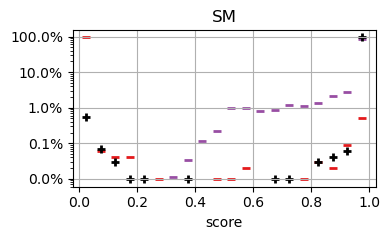

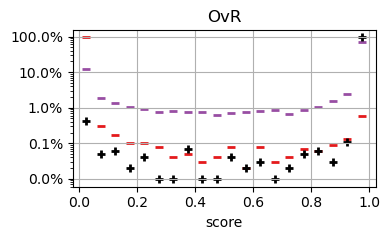

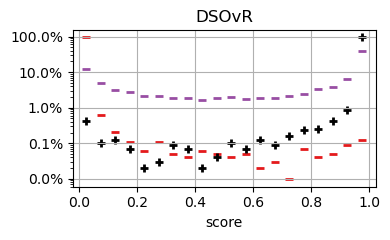

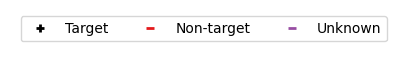

In [246]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

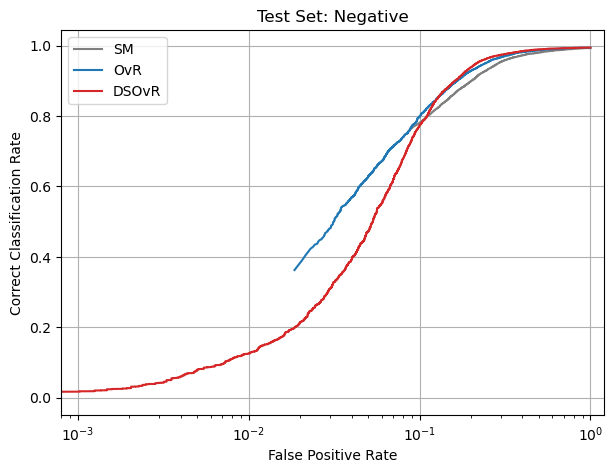

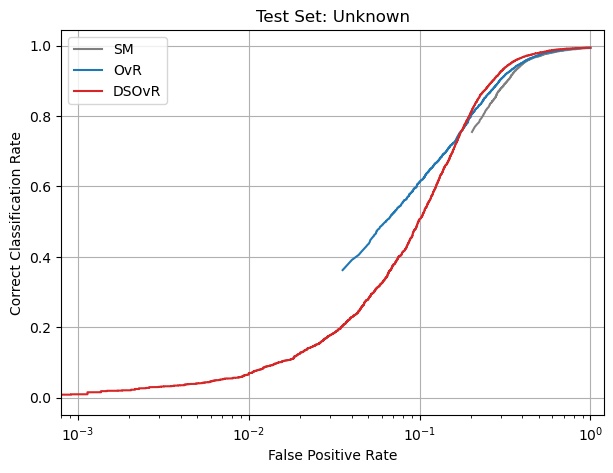

In [247]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

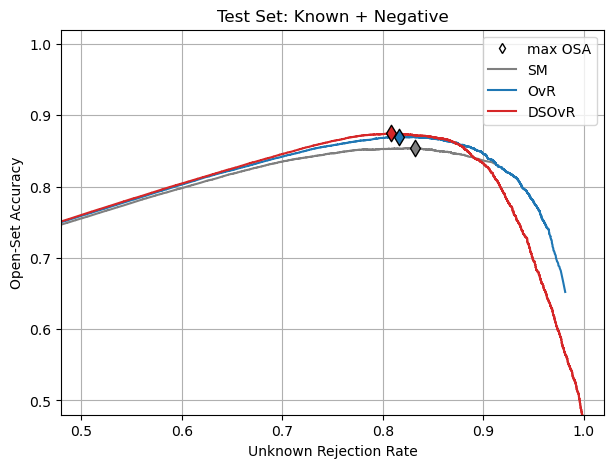

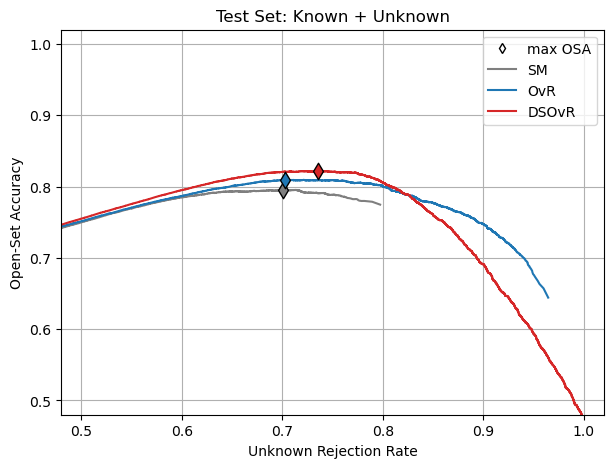

In [248]:
colors = [CMAP_t10[7],CMAP_t10[0],CMAP_t10[3]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

### Result 2. Loss weighting approaches for data imbalance issue
RQ2. Which loss weighting approach for a set of one-vs-rest classifiers reduces performance imbalance, and how does it impact overall classification performance?

OvR vs. -C vs. -F vs. -M

DSOvR vs. -C vs. -F vs. -M

- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve

#### OvR

In [326]:
data_info = sm_data_info_1 + ovr_data_info_2

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_b', 'OvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_02', 'OvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_06', 'OvR']


In [327]:
results = evals.print_metrics(data_info, has_neg=False)

FPR↓	FNR↓	maxOSA_U↑
0.0496	0.0069	0.7954
0.0442	0.0071	0.8098
0.0587	0.0050	0.8224
0.0408	0.0091	0.8437
0.0439	0.0077	0.8492


[0.56 0.07 0.03 0.01] [9.916e+01 6.000e-02 4.000e-02 4.000e-02]
[0.43 0.05 0.06 0.02] [97.89  0.3   0.17  0.1 ]
[0.19 0.08 0.03 0.02] [92.32  1.3   0.92  0.61]
[0.7  0.05 0.06 0.01] [9.844e+01 1.900e-01 8.000e-02 8.000e-02]
[0.49 0.05 0.05 0.04] [97.59  0.39  0.14  0.1 ]


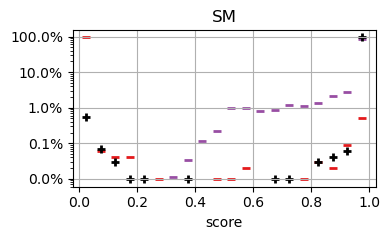

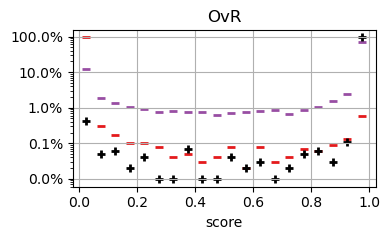

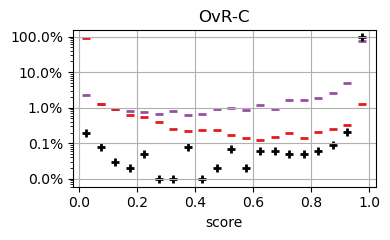

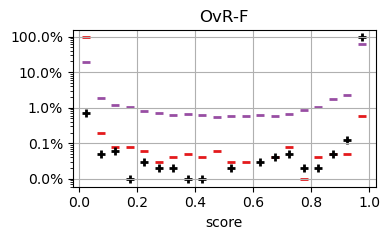

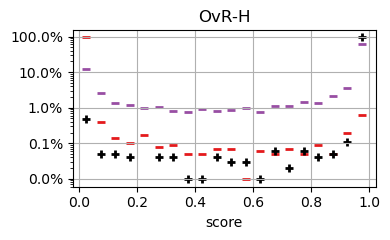

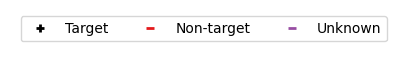

In [328]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

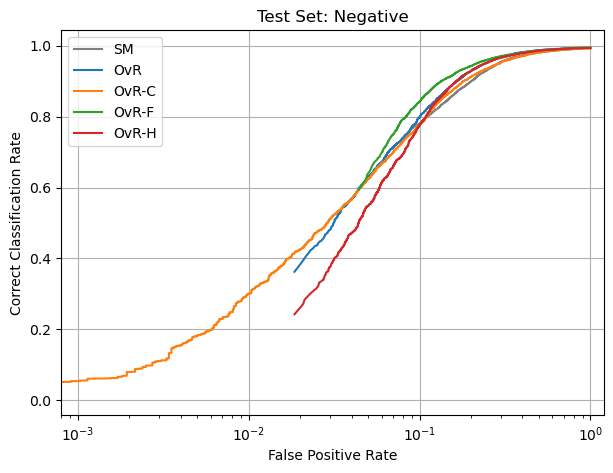

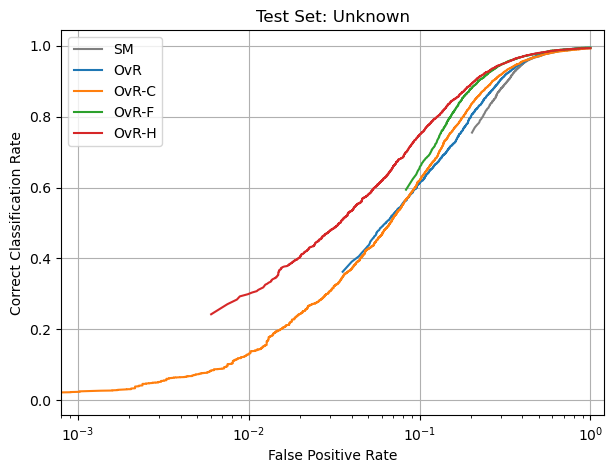

In [331]:
evals.plot_OSCR(data_info, [CMAP_t10[7]]+CMAP_t10, figsize=(7,5), show_val=False)

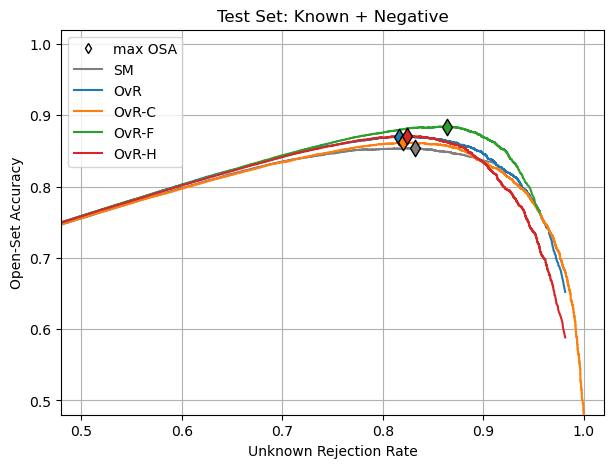

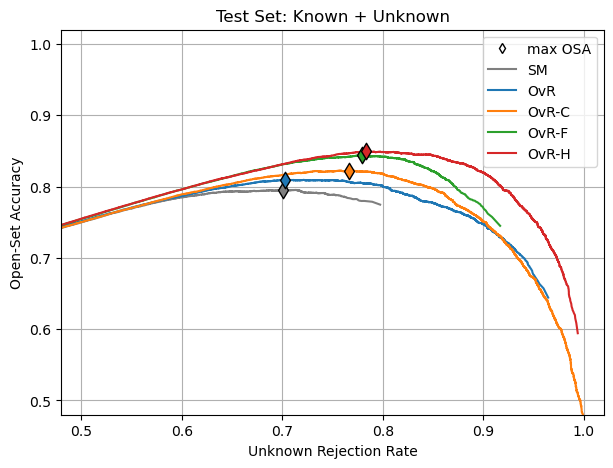

In [332]:
evals.plot_OSAC(data_info, [CMAP_t10[7]]+CMAP_t10, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

#### DSOvR

In [334]:
data_info = sm_data_info_1+dsovr_data_info_2

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'SoftMax']
['SmallScale', '_RQ1', 'LeNet_neg_0', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_F_neg_0_3', 'OpenSetOvR']
['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OpenSetOvR']


In [335]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0496	0.0069	0.8540	0.7954
0.0343	0.0098	0.8745	0.8218
0.0457	0.0054	0.8702	0.8152
0.0383	0.0100	0.8809	0.8243
0.0377	0.0094	0.8691	0.8157


[0.56 0.07 0.03 0.01] [9.916e+01 6.000e-02 4.000e-02 4.000e-02]
[0.42 0.1  0.12 0.07] [98.15  0.64  0.21  0.11]
[0.15 0.03 0.02 0.06] [94.54  1.4   0.72  0.48]
[0.18 0.12 0.02 0.17] [94.37  2.35  0.96  0.47]
[0.33 0.11 0.08 0.08] [97.08  0.86  0.32  0.35]


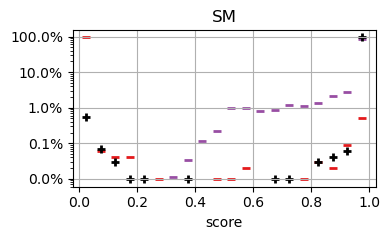

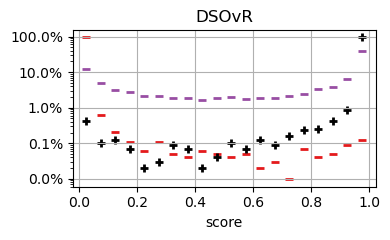

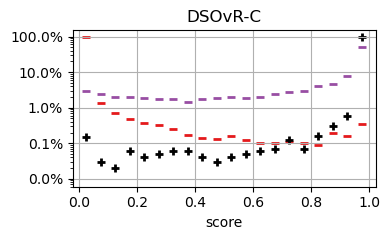

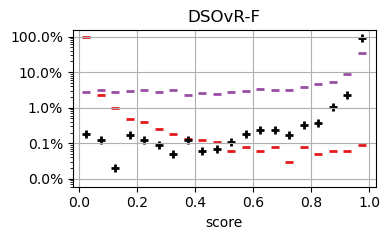

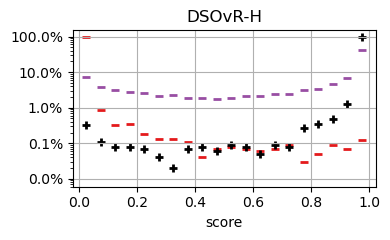

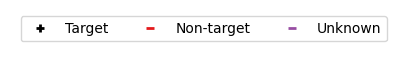

In [336]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[-1],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=False)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

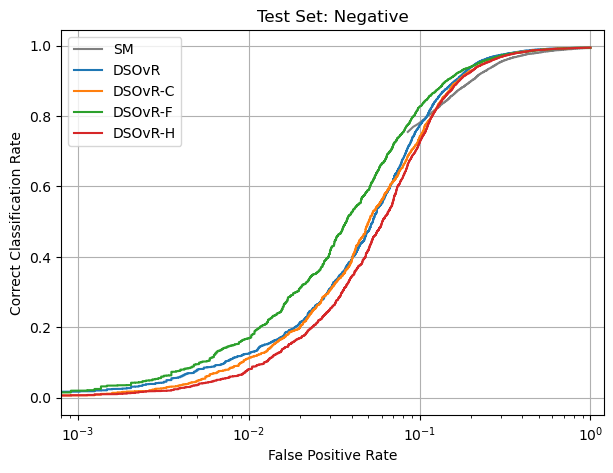

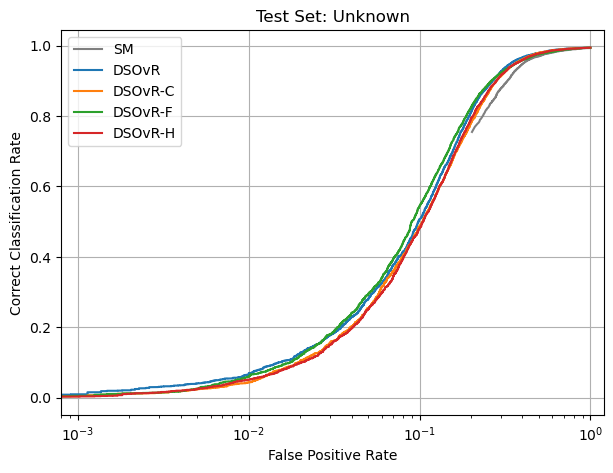

In [337]:
evals.plot_OSCR(data_info, [CMAP_t10[7]]+CMAP_t10, figsize=(7,5), show_val=False)

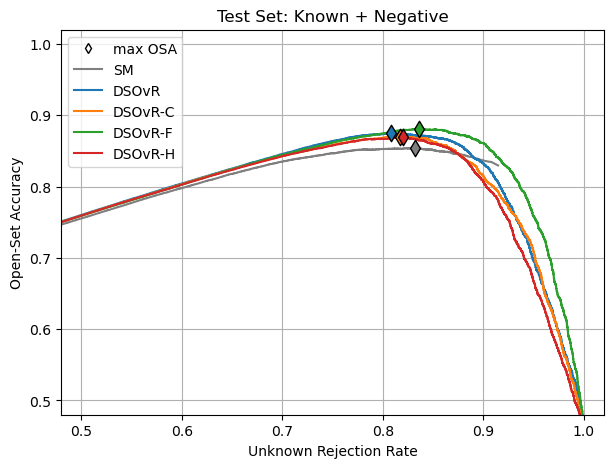

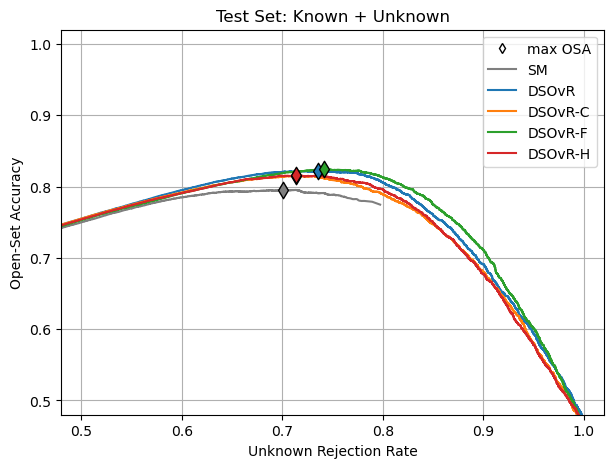

In [338]:
evals.plot_OSAC(data_info, [CMAP_t10[7]]+CMAP_t10, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True))

### Result 3.Including negatives in training 

RQ3. Does including negative samples in training improve open-set classification performance, and can loss weighting approaches mitigate the negative effects of increased dataset imbalance?

.
- OvR vs. OvR (- 10k) vs. OvR (- 20k) vs. OvR (- 30k) vs. OvR (- All) 
- OvR-C vs. OvR-C (- 10k) vs. OvR-C (- 20k) vs. OvR-C (- 30k) vs. OvR-C (- All) 
- OvR-F vs. OvR-F (- 10k) vs. OvR-F (- 20k) vs. OvR-F (- 30k) vs. OvR-F (- All) 
- OvR-H vs. OvR-H (- 10k) vs. OvR-H (- 20k) vs. OvR-H (- 30k) vs. OvR-H (- All) 

.
- DSOvR vs. DSOvR (- 10k) vs. DSOvR (- 20k) vs. DSOvR (- 30k) vs. DSOvR (- All) 
- DSOvR-C vs. DSOvR-C (- 10k) vs. DSOvR-C (- 20k) vs. DSOvR-C (- 30k) vs. DSOvR-C (- All) 
- DSOvR-F vs. DSOvR-F (- 10k) vs. DSOvR-F (- 20k) vs. DSOvR-F (- 30k) vs. DSOvR-F (- All) 
- DSOvR-H vs. DSOvR-H (- 10k) vs. DSOvR-H (- 20k) vs. DSOvR-H (- 30k) vs. DSOvR-H (- All) 

.
- Accuracy
- Confusion Matrix with '-1'
- Score distribution
    - Target = P_c
    - Non-Target = max{t is not c}P_t
    - Negative = max{t}P_t
    - Unknown = max{t}P_t
- |FPR-FNR|
- OSCR Curve
- OSA Curve


#### OvR

##### X

In [259]:
data_info = ovr_data_info_2[:1]
data_info += ovr_data_info_3_10k[:1] + ovr_data_info_3_20k[:1] + ovr_data_info_3_30k[:1] + ovr_data_info_3[:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']


In [260]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0442	0.0071	0.8700	0.8098
0.0208	0.0211	0.9738	0.8671
0.0201	0.0226	0.9747	0.8454
0.0213	0.0220	0.9764	0.8534
0.0164	0.0279	0.9780	0.8589


##### C

In [261]:
data_info = ovr_data_info_2[1:2]
data_info += ovr_data_info_3_10k[1:2] + ovr_data_info_3_20k[1:2] + ovr_data_info_3_30k[1:2] + ovr_data_info_3[1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_C_neg_0_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']


In [262]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0587	0.0050	0.8624	0.8224
0.0232	0.0137	0.9734	0.8529


0.0211	0.0170	0.9744	0.8629
0.0202	0.0220	0.9761	0.8522
0.0202	0.0177	0.9801	0.8605


##### F

In [263]:
data_info = ovr_data_info_2[2:3]
data_info += ovr_data_info_3_10k[2:3] + ovr_data_info_3_20k[2:3] + ovr_data_info_3_30k[2:3] + ovr_data_info_3[2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_F_neg_0_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_3', 'OvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_3', 'OvR']


In [264]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0408	0.0091	0.8843	0.8437
0.0215	0.0148	0.9760	0.8684
0.0203	0.0187	0.9763	0.8604
0.0191	0.0200	0.9793	0.8677
0.0180	0.0265	0.9789	0.8609


##### M

In [265]:
data_info = ovr_data_info_2[3:]
data_info += ovr_data_info_3_10k[3:] + ovr_data_info_3_20k[3:] + ovr_data_info_3_30k[3:] + ovr_data_info_3[3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_M_neg_0_06', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_02', 'OvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_02', 'OvR']


In [266]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0439	0.0077	0.8715	0.8492
0.0229	0.0244	0.9733	0.8351
0.0185	0.0280	0.9732	0.8543
0.0212	0.0231	0.9780	0.8530
0.0192	0.0229	0.9787	0.8579


##### Plots

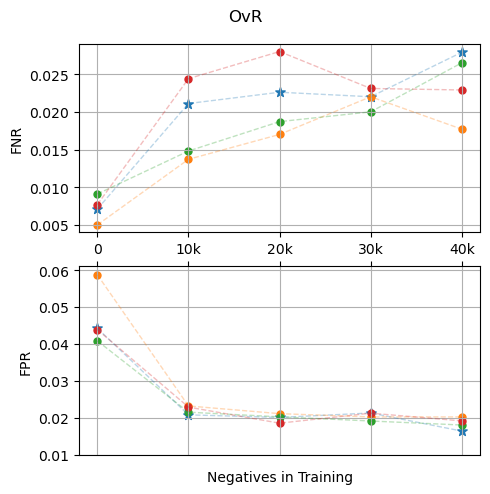

In [267]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
ylim = [(0.004,0.029),(0.01,0.061)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='--', lw=1, alpha=0.3)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='--', lw=1, alpha=0.3)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(5), ['0','10k','20k','30k','40k'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(5), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

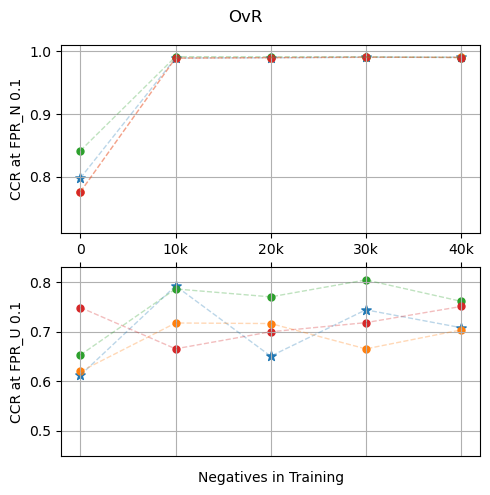

In [268]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
ylim = [(0.71,1.01),(0.45,0.83)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='--', lw=1, alpha=0.3)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='--', lw=1, alpha=0.3)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(5), ['0','10k','20k','30k','40k'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(5), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

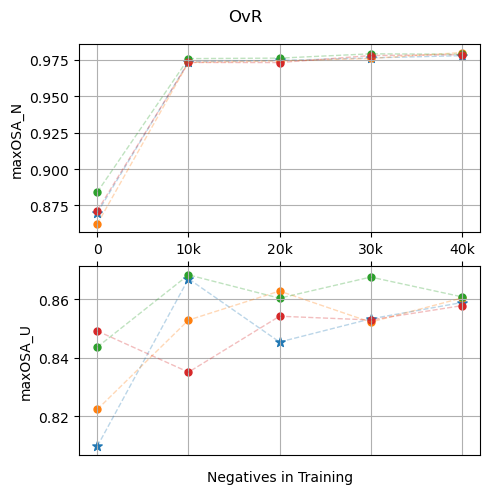

In [269]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
ylim = [(0.85,1.0),(0.79,0.85)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='--', lw=1, alpha=0.3)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='--', lw=1, alpha=0.3)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(5), ['0','10k','20k','30k','40k'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(5), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

#### DSOvR

##### X

In [270]:
data_info = dsovr_data_info_2[:1]
data_info += dsovr_data_info_3_10k[:1] + dsovr_data_info_3_20k[:1] + dsovr_data_info_3_30k[:1] + dsovr_data_info_3[:1]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ1', 'LeNet_neg_0', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_10k', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_20k', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_30k', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OpenSetOvR']


In [271]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0343	0.0098	0.8745	0.8218
0.0189	0.0199	0.9760	0.8553
0.0174	0.0237	0.9782	0.8546
0.0170	0.0260	0.9776	0.8573
0.0166	0.0276	0.9805	0.8526


##### C

In [272]:
data_info = dsovr_data_info_2[1:2]
data_info += dsovr_data_info_3_10k[1:2] + dsovr_data_info_3_20k[1:2] + dsovr_data_info_3_30k[1:2] + dsovr_data_info_3[1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_C_neg_0_g', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_10k_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_20k_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_30k_b', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OpenSetOvR']


In [273]:
results_c = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0457	0.0054	0.8702	0.8152
0.0235	0.0146	0.9738	0.8536
0.0205	0.0152	0.9789	0.8579
0.0209	0.0174	0.9791	0.8632
0.0203	0.0155	0.9817	0.8630


##### F

In [274]:
data_info = dsovr_data_info_2[2:3]
data_info += dsovr_data_info_3_10k[2:3] + dsovr_data_info_3_20k[2:3] + dsovr_data_info_3_30k[2:3] + dsovr_data_info_3[2:3]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_F_neg_0_3', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_10k_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_20k_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_30k_2', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_F_neg_All_2', 'OpenSetOvR']


In [275]:
results_f = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0383	0.0100	0.8809	0.8243
0.0205	0.0190	0.9733	0.8611
0.0195	0.0216	0.9754	0.8599
0.0192	0.0223	0.9790	0.8533
0.0176	0.0254	0.9809	0.8605


##### M

In [276]:
data_info = dsovr_data_info_2[3:]
data_info += dsovr_data_info_3_10k[3:] + dsovr_data_info_3_20k[3:] + dsovr_data_info_3_30k[3:] + dsovr_data_info_3[3:]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ2', 'LeNet_M_neg_0_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_10k_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_20k_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_30k_04', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_M_neg_All_04', 'OpenSetOvR']


In [277]:
results_h = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑
0.0377	0.0094	0.8691	0.8157


0.0187	0.0210	0.9755	0.8537
0.0183	0.0232	0.9777	0.8561
0.0175	0.0236	0.9785	0.8554
0.0162	0.0277	0.9811	0.8587


##### Plots

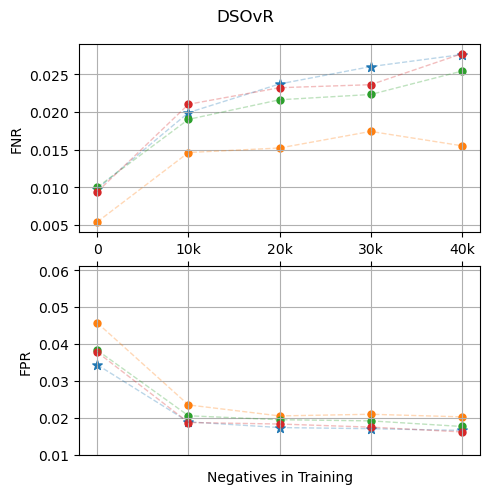

In [278]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
ylim = [(0.004,0.029),(0.01,0.061)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['fnr_avg'] for r in res['res_fpr_fnr']], ls='--', lw=1, alpha=0.3)
    axs[0].scatter(x,[r['fnr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)
    axs[1].plot([r['fpr_avg'] for r in res['res_fpr_fnr']], ls='--', lw=1, alpha=0.3)
    axs[1].scatter(x,[r['fpr_avg'] for r in res['res_fpr_fnr']], marker=marker, s=size)

axs[0].set_ylabel('FNR')
axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(5), ['0','10k','20k','30k','40k'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('FPR')
axs[1].set_xticks(range(5), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

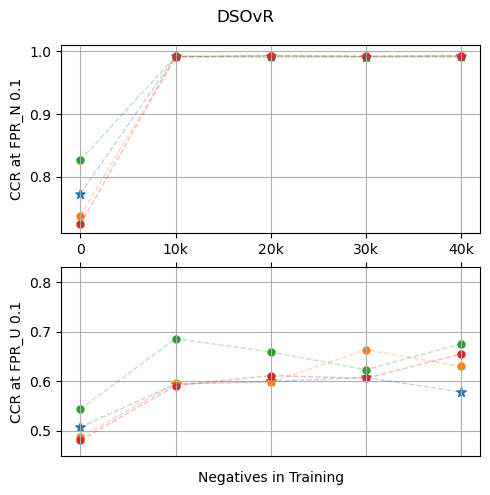

In [279]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
ylim = [(0.71,1.01),(0.45,0.83)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['negative'] for r in res['oscr']], ls='--', lw=1, alpha=0.3)
    axs[0].scatter(x,[r['negative'] for r in res['oscr']], marker=marker, s=size)
    axs[1].plot([r['unknown'] for r in res['oscr']], ls='--', lw=1, alpha=0.3)
    axs[1].scatter(x,[r['unknown'] for r in res['oscr']], marker=marker, s=size)

axs[0].set_ylabel('CCR at FPR_N 0.1')
axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(5), ['0','10k','20k','30k','40k'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('CCR at FPR_U 0.1')
axs[1].set_xticks(range(5), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('DSOvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

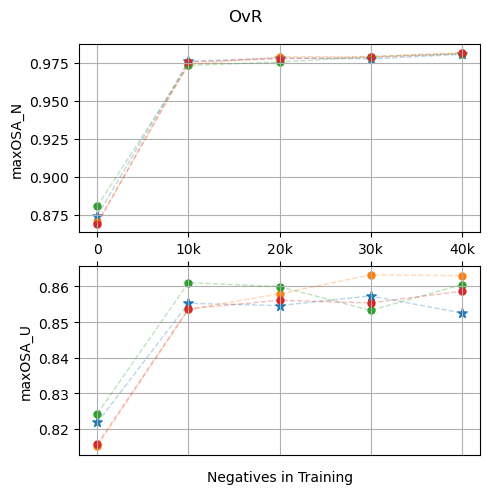

In [280]:
fig, axs = plt.subplots(2,1, figsize=(5,5))
ylim = [(0.85,1.0),(0.79,0.85)]

for idx, res in enumerate([results, results_c, results_f, results_h]):
    marker = 'o'
    size = 25
    if idx == 0:
        marker = '*'
        size = 50

    x = range(len(res['res_fpr_fnr']))
    axs[0].plot([r['iosa_neg'] for r in res['oosa']], ls='--', lw=1, alpha=0.3)
    axs[0].scatter(x,[r['iosa_neg'] for r in res['oosa']], marker=marker, s=size)
    axs[1].plot([r['iosa_unkn'] for r in res['oosa']], ls='--', lw=1, alpha=0.3)
    axs[1].scatter(x,[r['iosa_unkn'] for r in res['oosa']], marker=marker, s=size)

axs[0].set_ylabel('maxOSA_N')
# axs[0].set_ylim(ylim[0])
axs[0].set_xticks(range(5), ['0','10k','20k','30k','40k'])
axs[0].tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
axs[0].grid()

axs[1].set_ylabel('maxOSA_U')
axs[1].set_xticks(range(5), [])
axs[1].tick_params(top=True, labeltop=False, bottom=False, labelbottom=True)
axs[1].set_xlabel('Negatives in Training')
# axs[1].set_ylim(ylim[1])
axs[1].grid()

fig.suptitle('OvR')
fig.tight_layout()
plt.subplots_adjust(hspace=0.18)

#### Overall

- 40k Negatives in training
- EOS vs. OvR-C vs. DSOvR-C

In [308]:
data_info = eos_data_info_3[-1:] + ovr_data_info_3[:1] + ovr_data_info_3[1:2] + dsovr_data_info_3[:1] + dsovr_data_info_3[1:2]

for idx in range(len(data_info)):
    print(data_info[idx]['info'])

['SmallScale', '_RQ3', 'LeNet_neg_All', 'EOS']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OvR']
['SmallScale', '_RQ3', 'LeNet_neg_All', 'OpenSetOvR']
['SmallScale', '_RQ3', 'LeNet_C_neg_All_b', 'OpenSetOvR']


In [309]:
results = evals.print_metrics(data_info)

FPR↓	FNR↓	maxOSA_N↑	maxOSA_U↑


0.0213	0.0405	0.9619	0.8483
0.0164	0.0279	0.9780	0.8589
0.0202	0.0177	0.9801	0.8605
0.0166	0.0276	0.9805	0.8526
0.0203	0.0155	0.9817	0.8630


[0.62 0.4  0.66 0.4 ] [92.75  2.34  1.6   0.65]
[2.12 0.11 0.13 0.05] [9.896e+01 1.700e-01 3.000e-02 5.000e-02]


[1.2  0.14 0.15 0.03] [9.816e+01 2.700e-01 1.400e-01 9.000e-02]
[1.14 0.33 0.24 0.22] [98.51  0.39  0.19  0.16]
[0.57 0.16 0.14 0.11] [96.78  1.01  0.51  0.35]


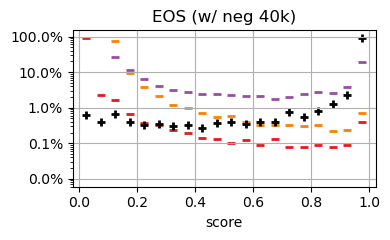

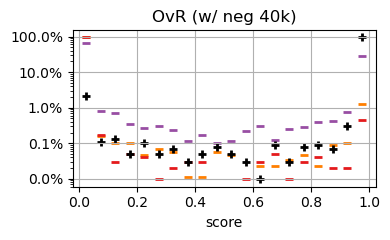

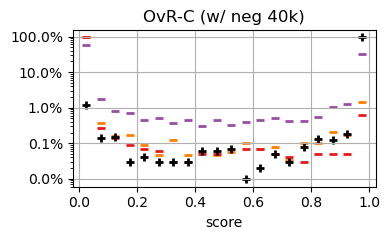

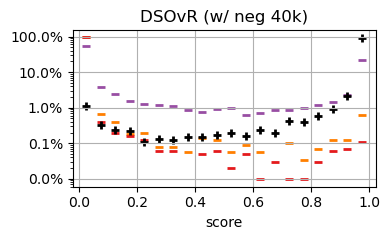

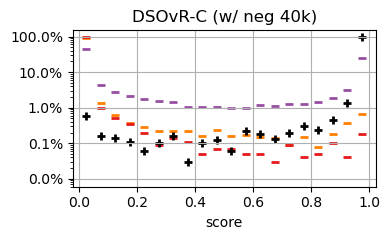

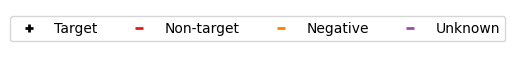

In [310]:
start, stop, step = 0, 1, 0.05
colors=('black',CMAP_s1[0],CMAP_s1[4],CMAP_s1[3])
bins = np.arange(start=start,stop=stop+step, step=step)
legend = evals.plot_score_dist(data_info, bins, colors=colors, figsize=(4,2.5), ylim=(6e-3,150), plot_neg=True)

# Composing separate legend plot
labels = ['Target', 'Non-target', 'Negative', 'Unknown']
legend_elements = [Line2D([0], [0], color=colors[0], lw=0, label=labels[0], marker='+', markeredgewidth=2),
                  Line2D([0], [0], color=colors[1], lw=0, label=labels[1], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[2], lw=0, label=labels[2], marker='_', markeredgewidth=2),
                  Line2D([0], [0], color=colors[3], lw=0, label=labels[3], marker='_', markeredgewidth=2),]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, loc='center', ncol=4)
ax.axes.axis("off")
plt.show()

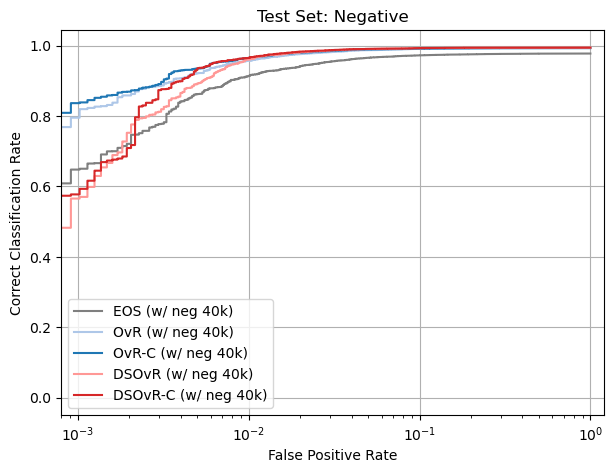

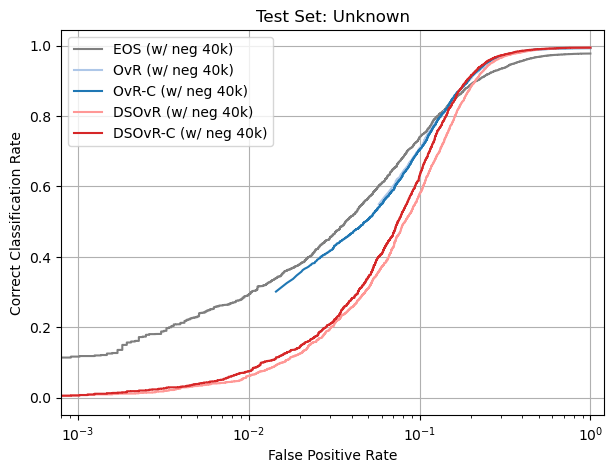

In [311]:
colors = [CMAP_t10[7]]+ [CMAP_t20[1],CMAP_t20[0]] + [CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSCR(data_info, colors, figsize=(7,5), show_val=False)

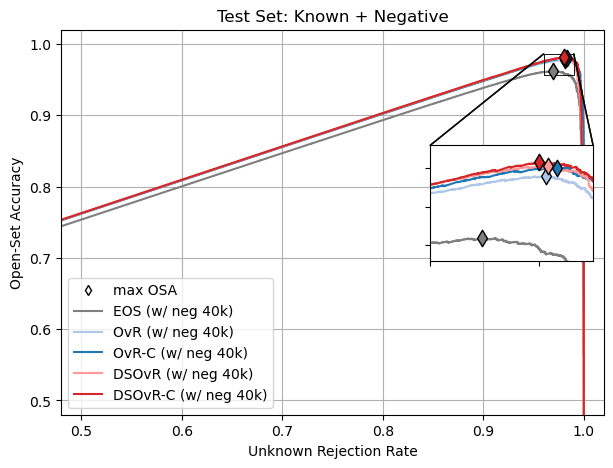

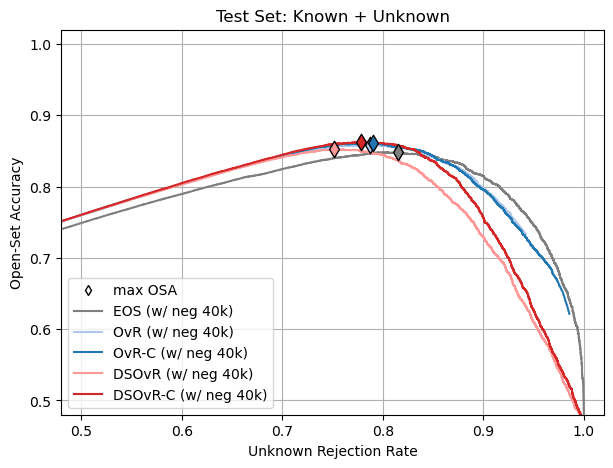

In [322]:
colors = [CMAP_t10[7]]+ [CMAP_t20[1],CMAP_t20[0]] + [CMAP_t20[7],CMAP_t20[6]]
evals.plot_OSAC(data_info, colors, figsize=(7,5), 
                lim=((0.48,1.02),(0.48,1.02)), show_val=False, show_point=(False,True),
                zoom=((True,(0.96,0.99,0.956,0.986),(0.68,0.4,0.3,0.3)),(False,(0,0,0,0),(0,0,0,0))))

#### Legend

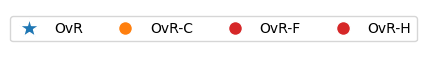

In [299]:
# Composing separate legend plot
labels = ['OvR', 'OvR-C', 'OvR-F', 'OvR-H']
legend_elements = [
    Line2D([0], [0], markerfacecolor=CMAP_t10[0], color='w',marker='*', markersize=15),
    Line2D([0], [0], markerfacecolor=CMAP_t10[1], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, labels = labels, loc='center', ncol=4, 
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.axes.axis("off")
plt.show()

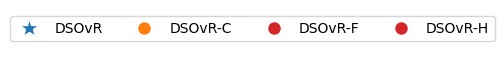

In [300]:
# Composing separate legend plot
labels = ['DSOvR', 'DSOvR-C', 'DSOvR-F', 'DSOvR-H']
legend_elements = [
    Line2D([0], [0], markerfacecolor=CMAP_t10[0], color='w',marker='*', markersize=15),
    Line2D([0], [0], markerfacecolor=CMAP_t10[1], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
    Line2D([0], [0], markerfacecolor=CMAP_t10[3], color='w',marker='o', markersize=10),
]
# Create the figure
fig, ax = plt.subplots(figsize=(5,0.5))
ax.legend(handles=legend_elements, labels = labels, loc='center', ncol=4, 
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.axes.axis("off")
plt.show()

### __ Feature space dimensionality

In [301]:
data_info = ovr_data_info_D + dsovr_data_info_D
for idx in range(len(data_info)):
    print(idx, data_info[idx]['info'])

0 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2', 'OvR']
1 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5', 'OvR']
2 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10', 'OvR']
3 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3', 'OvR']
4 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C4', 'OvR']
5 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2_neg_All', 'OvR']
6 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5_neg_All', 'OvR']
7 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10_neg_All', 'OvR']
8 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C3_neg_All', 'OvR']
9 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C4_neg_All', 'OvR']
10 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F3C10_neg_All', 'OvR']
11 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C2', 'OpenSetOvR']
12 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C5', 'OpenSetOvR']
13 ['SmallScale', '_Discussion', 'LeNet_plus_plus_F2C10', 'OpenSetOvR']
14 ['SmallScale', '_Discussion', 'LeNet_p

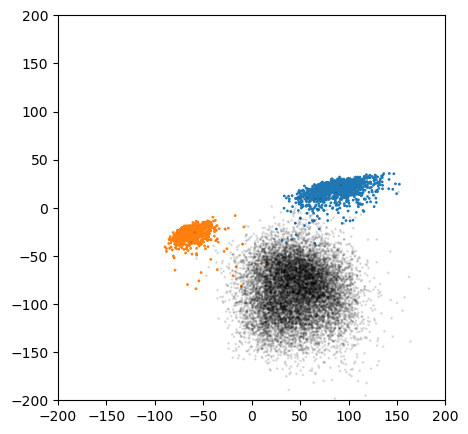

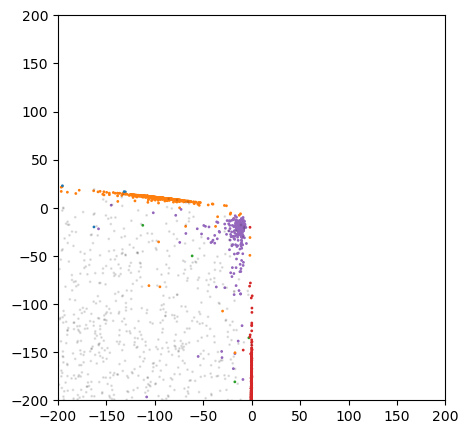

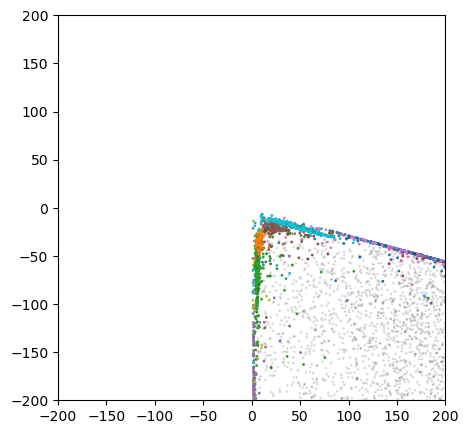

In [302]:
for i in [5,6,7]:
    plt.figure(figsize=(5,5))
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP_t10[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]

    plt.scatter(val_feats[:,0], val_feats[:,1], color=pnt_color, s=1, alpha=pnt_alpha)
    plt.xlim((-200,200))
    plt.ylim((-200,200))

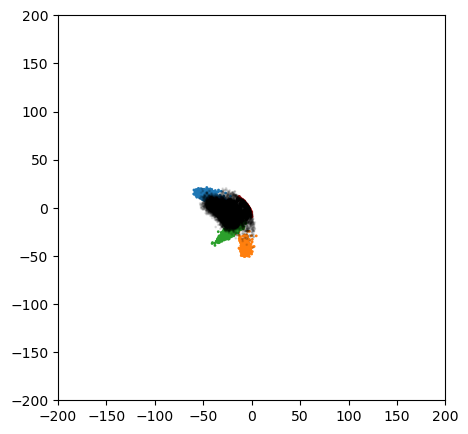

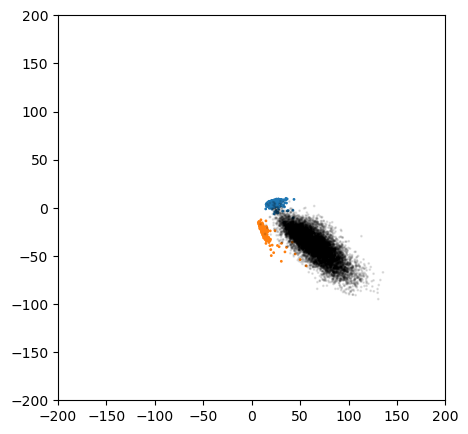

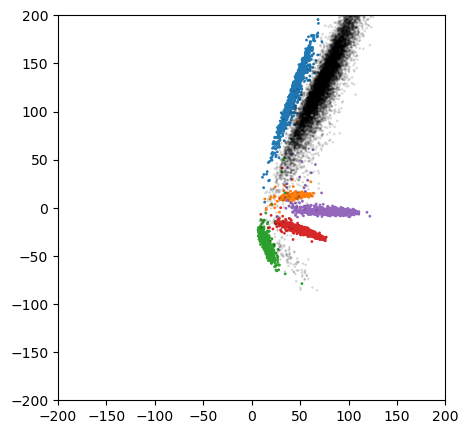

In [303]:
for i in [15,16,17]:
    plt.figure(figsize=(5,5))
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP_t10[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]

    plt.scatter(val_feats[:,0], val_feats[:,1], color=pnt_color, s=1, alpha=pnt_alpha)
    plt.xlim((-200,200))
    plt.ylim((-200,200))

In [304]:
np.unique(val_gt)

array([-1,  0,  1,  2,  3,  4])

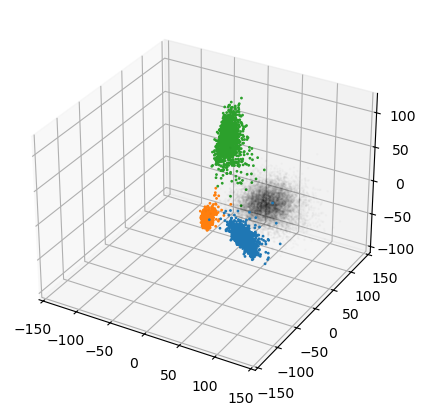

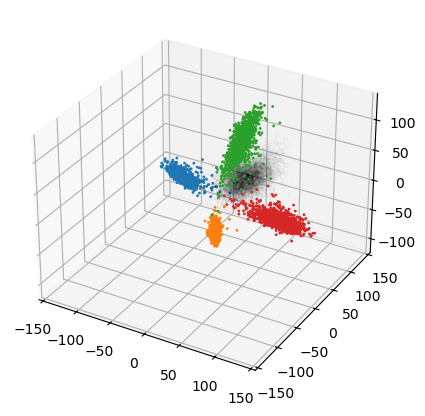

In [305]:
for i in [8,9]:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP_t10[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]
    pnt_size = [1]*len(val_gt)

    for c in np.unique(val_gt):
        if c == -1:
            color = 'black'
            alpha = 0.01
        else:
            color = CMAP_t10[c]
            alpha = 1
        ax.scatter(val_feats[val_gt==c,0], val_feats[val_gt==c,1], val_feats[val_gt==c,2],
                   color=color, alpha=alpha, s=1)

    # print(val_feats[:,0].shape, val_gt.shape)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2],)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2], 
    #            s=1)
    ax.set_xlim((-150,150))
    ax.set_ylim((-150,150))

IndexError: index 2 is out of bounds for axis 1 with size 2

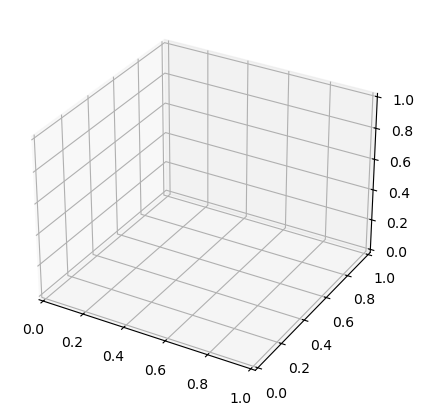

In [306]:
for i in [18,19]:
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(projection='3d')
    info = data_info[i]['info']

    root_path = f'/home/user/hkim/UZH-MT/openset-binary/_results/{info[0]}/_s42/{info[1]}/eval_{info[2]}/{info[3]}'
    eval_res = evals.eval_results(root_path, load_feats=True)

    val_gt = eval_res.val_gt
    val_feats = eval_res.val_feats
    pnt_color = [CMAP_t10[gt] if gt != -1 else 'black' for gt in val_gt]
    pnt_alpha = [1 if gt != -1 else 0.1 for gt in val_gt]
    pnt_size = [1]*len(val_gt)

    for c in np.unique(val_gt):
        if c == -1:
            color = 'black'
            alpha = 0.01
        else:
            color = CMAP_t10[c]
            alpha = 1
        ax.scatter(val_feats[val_gt==c,0], val_feats[val_gt==c,1], val_feats[val_gt==c,2],
                   color=color, alpha=alpha, s=1)

    # print(val_feats[:,0].shape, val_gt.shape)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2],)
    # ax.scatter(val_feats[:,0], val_feats[:,1], val_feats[:,2], 
    #            s=1)
    ax.set_xlim((-150,150))
    ax.set_ylim((-150,150))